# Proyecto NLP Quijote

**Objetivo**
Creación de un modelo de Deep Learning entrenado con los primeros **50 capitulos del Quijote**, para crear una contextualización artificial del contenido del libro y de esta manera poder predecir un nuevo texto en función a unas palabras dadas.

**Requisitos**
* Python 3.8
* Tensorflow 2.x

**Pasos de creación**
* Adquirir el libro del Quijote en formato digital. https://www.gutenberg.org/ebooks/search/?query=quijote&submit_search=Go%21
* Tratamiento de los datos
* Creación del modelo usando redes LSTM (Large Short Term Memory)
* Entrenamiento
* Resultados y validación
* Prediccón
* Salvar modelo

In [1]:
#Cargamos las librerias correspondientes
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import re

### Tokenizer
Como la palabra sugiere tokenizar significa dividir la oración en una serie de tokens o en palabras simples, podemos decir que cada vez que hay un espacio en una oración agregamos una coma entre ellos para que nuestra oración se divida en tokens y cada palabra tenga un valor único de un número entero.

In [2]:
tokenizer = Tokenizer()

data = open('Dataset/quijote_Lite.txt', encoding="utf8").read()
#data = open('/content/drive/My Drive/Colab Notebooks/Datasets/Vuelta_al_mundo.txt').read()

#Limpiar de simbolos 
data = re.sub('[^a-zA-Z0-9á-ú\¿\?\n\.]', ' ', data)
corpus = data.lower().split("\n")

#Mostramos el cuerpo del texto ya limpio
print(corpus)
corpus = sorted(list(set(corpus)))

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1



['capítulo primero. que trata de la condición y ejercicio del famoso hidalgo', 'don quijote de la mancha', '', '', 'en un lugar de la mancha  de cuyo nombre no quiero acordarme  no ha mucho', 'tiempo que vivía un hidalgo de los de lanza en astillero  adarga antigua ', 'rocín flaco y galgo corredor. una olla de algo más vaca que carnero ', 'salpicón las más noches  duelos y quebrantos los sábados  lantejas los', 'viernes  algún palomino de añadidura los domingos  consumían las tres', 'partes de su hacienda. el resto della concluían sayo de velarte  calzas de', 'velludo para las fiestas  con sus pantuflos de lo mesmo  y los días de', 'entresemana se honraba con su vellorí de lo más fino. tenía en su casa una', 'ama que pasaba de los cuarenta  y una sobrina que no llegaba a los veinte ', 'y un mozo de campo y plaza  que así ensillaba el rocín como tomaba la', 'podadera. frisaba la edad de nuestro hidalgo con los cincuenta años  era de', 'complexión recia  seco de carnes  enjuto de rostro 

### Resultado despues de realizar los **tokens**

In [3]:
print(tokenizer.word_index)
print(total_words)
print(corpus)
print(len(corpus))

{'que': 1, 'de': 2, 'y': 3, 'la': 4, 'a': 5, 'en': 6, 'el': 7, 'no': 8, 'se': 9, 'los': 10, 'con': 11, 'por': 12, 'su': 13, 'lo': 14, 'le': 15, 'las': 16, 'como': 17, 'me': 18, 'del': 19, 'don': 20, 'es': 21, 'más': 22, 'si': 23, 'yo': 24, 'un': 25, 'al': 26, 'dijo': 27, 'quijote': 28, 'porque': 29, 'mi': 30, 'tan': 31, 'él': 32, 'para': 33, 'sancho': 34, 'había': 35, 'ni': 36, 'sin': 37, 'todo': 38, 'una': 39, 'bien': 40, 'así': 41, 'o': 42, 'ser': 43, 'era': 44, 'sus': 45, 'esto': 46, 'ha': 47, 'pues': 48, 'respondió': 49, 'ya': 50, 'pero': 51, 'todos': 52, 'vuestra': 53, 'cual': 54, 'señor': 55, 'cuando': 56, 'ella': 57, 'merced': 58, 'fue': 59, 'donde': 60, 'te': 61, 'caballero': 62, 'sino': 63, 'hacer': 64, 'quien': 65, 'muy': 66, 'aquel': 67, 'dos': 68, 'este': 69, 'otra': 70, 'aunque': 71, 'estaba': 72, 'cosa': 73, 'esta': 74, 'allí': 75, 'qué': 76, 'decir': 77, 'otro': 78, 'he': 79, 'nos': 80, 'tanto': 81, 'luego': 82, 'cura': 83, 'poco': 84, 'mí': 85, 'mal': 86, 'señora': 87, 

#### Preparación de los datos
Para mejorar el entrenamiento del modelo y poder tener más datos a partir de los obtenidos, se realiza una tecnica llamda **secuencia**. Que consiste en dividir cada oración en una más pequeña en forma de escalera, de esta forma se hará una predicción de entrenamiento por cada subdivisión de esa oración.

<img src="images/secuencias.png">

Posteriormente se realiza un **Padding**. Es un método para convertir la matriz de enteros de longitud variable en una longitud fija, ya sea truncando (si la longitud es mayor que la longitud_máxima definida que trunca la matriz) o rellenando (si la longitud es más corta que la longitud_máxima, rellene la matriz con 0).

<img src="images/Padding.png">

In [4]:
input_sequences = []
#Marcamos los tokens por cada frase
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	#Creamos frases más pequeñas en función a al original
	#for i in range(1, len(token_list)):
	for i in range(1, len(token_list)): #usamos cada frase para aumentar el train en modo de escalera
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
#Buscamos la frase más larga y las igualamos todas con ceros en la parte de adelante
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
#Cogemos el ultimo valor como etiqueta (y) y el resto como (x)
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

**Mostramos algunos ejemplos del proceso**

In [6]:
print(xs[5])
print(ys[5])
print(ys.shape)
print(xs.shape)

[   0    0    0    0    0    0    0    0    0    0    0    0  119 1725
    1 4532    5   25]
[0. 0. 0. ... 0. 0. 0.]
(153835, 13850)
(153835, 18)


### Creación del modelo

* La primera capa incluye el número de palabras a entrenar y la salida de predicción que queremos mostrar, en este caso se hará una predicción de 50 palabras en función a la dada.

* Usamos como optimizador Adam, aunque tambien se optienen buenos resultados con RMSprop

In [8]:
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))
#model.add(Bidirectional(LSTM(128)))
#model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100,activation='relu'))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.001)
rms=RMSprop(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
#filepath="/content/drive/My Drive/Colab Notebooks/Projects/QuijoteNLP/model/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
filepath="model/weights-QuijoteNLP.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 50)            692500    
_________________________________________________________________
lstm_2 (LSTM)                (None, 18, 100)           60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 13850)             1398850   
Total params: 2,242,250
Trainable params: 2,242,250
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(xs, ys, epochs=50, batch_size=128, verbose=1,callbacks=callbacks_list)

Epoch 1/50
1201/1202 [============================>.] - ETA: 0s - loss: 6.5500 - accuracy: 0.0594
Epoch 00001: accuracy improved from -inf to 0.05943, saving model to /content/drive/My Drive/Colab Notebooks/Projects/QuijoteNLP/model/weights-improvement-01-6.5495-bigger.hdf5
1202/1202 [==============================] - 53s 44ms/step - loss: 6.5495 - accuracy: 0.0594
Epoch 2/50
1202/1202 [==============================] - ETA: 0s - loss: 6.0984 - accuracy: 0.0741
Epoch 00002: accuracy improved from 0.05943 to 0.07412, saving model to /content/drive/My Drive/Colab Notebooks/Projects/QuijoteNLP/model/weights-improvement-02-6.0984-bigger.hdf5
1202/1202 [==============================] - 50s 42ms/step - loss: 6.0984 - accuracy: 0.0741
Epoch 3/50
1202/1202 [==============================] - ETA: 0s - loss: 5.8654 - accuracy: 0.0917
Epoch 00003: accuracy improved from 0.07412 to 0.09170, saving model to /content/drive/My Drive/Colab Notebooks/Projects/QuijoteNLP/model/weights-improvement-03-5.

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

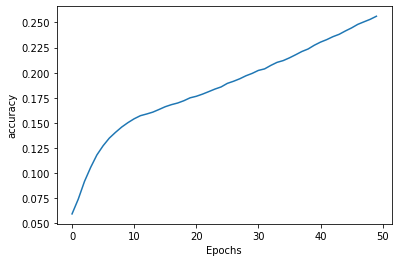

In [11]:
plot_graphs(history, 'accuracy')


## Predicción de un texto nuevo
* Le damos unas palabras para que pueda crear unas lineas contextualizadas en el Quijote.

In [ ]:
seed_text = "leer libros de caballerías"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

leer libros de caballerías en la verdad que yo no pienso que tengo no se te se temiendo mi señor don quijote y aun como si es de saber en lo que reparábamos se han de hacer y a este tiempo como ha de su nombre de la carta sobre un noche que una cosa que ahora más de veras su padre el mío que me tiene porque ni promesas que a su parecer de la mucha amistad ahora por sus suspiros y el agua blanco de haberlo las desgracias y puesto que a nosotros la cual ni puede lo que me cumple caso


#### Se guarda la predicción en un archivo de texto

In [ ]:
file = open("prediction.txt", "w") 
file.write(seed_text) 
file.close() 

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(13850, 100)


In [ ]:
#cantidad de palabras unicas
len(tokenizer.word_index.keys())

13849

In [ ]:
#Convertimos el diccionario en una lista, obteniendo solo las palabras
words_list = [(k) for k in tokenizer.word_index.keys()]

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(words_list):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>